In [9]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from pmdarima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import talib 
import json
import tensorflow as tf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
def mean_absolute_percentage_error(actual, prediction):
    actual = pd.Series(actual)
    prediction = pd.Series(prediction)
    return 100 * np.mean(np.abs((actual - prediction))/actual)

class PrintLogs(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs

    def set_params(self, params):
        params['epochs'] = 0

    def on_epoch_begin(self, epoch, logs=None):
        print('Epoch %d/%d' % (epoch + 1, self.epochs), end='\r')
    
    def on_epoch_end(self, epoch, logs=None):
        print('Epoch %d/%d' % (epoch + 1, self.epochs), end='\r')
    
    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys), end='\r')

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys), end='\r')

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys), end='\r')

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys), end='\r')

def get_arima(data, train_len, test_len, flag):
    data = data.tail(test_len + train_len).reset_index(drop=True)
    train = data.head(train_len).values.tolist()
    test = data.tail(test_len).values.tolist()
    data
    model = auto_arima(train, max_p=3, max_q=3, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
    
    model.fit(train)
    order = model.get_params()['order']
    print('ARIMA order:', order, '\n')
    
    if(flag == 1):
        order = (4,0,4)
    else: 
        order = (0,3,0)
    prediction = []
    for i in range(len(test)):
        model = pm.ARIMA(order=order)
        model.fit(train)
        print('working on', i+1, 'of', test_len, '-- ' + str(int(100 * (i + 1) / test_len)) + '% complete', end='\r')
        prediction.append(model.predict()[0])
        train.append(test[i])
    
    mse = mean_squared_error(test, prediction)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(pd.Series(test), pd.Series(prediction))
    return prediction, mse, rmse, mape, model

def get_lstm(data, train_len, test_len, lstm_len=4):
    data = data.tail(test_len + train_len).reset_index(drop=True)
    
    dataset = np.reshape(data.values, (len(data), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset_scaled = scaler.fit_transform(dataset)
    
    x_train = []
    y_train = []
    x_test = []
    
    for i in range(lstm_len, train_len):
        x_train.append(dataset_scaled[i - lstm_len:i, 0])
        y_train.append(dataset_scaled[i, 0])
    for i in range(train_len, len(dataset_scaled)):
        x_test.append(dataset_scaled[i - lstm_len:i, 0])

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    #print(x_test)
    model = Sequential()
    model.add(LSTM(units=lstm_len, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=int(lstm_len/2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    model.fit(x_train, y_train, epochs=50, batch_size=1, verbose=2, validation_split=0.2, callbacks=[PrintLogs(50), early_stopping])
    
    print(model.summary())
    #print(x_test)
    prediction = model.predict(x_test)
    prediction = scaler.inverse_transform(prediction).tolist()
    
    output = []
    for i in range(len(prediction)):
        output.extend(prediction[i])
    prediction = output
    
    mse = mean_squared_error(data.tail(len(prediction)).values, prediction)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(data.tail(len(prediction)).reset_index(drop=True), pd.Series(prediction))
    return prediction, mse, rmse, mape, x_test, model, scaler

def getOptimizedPeriods(data, talib_moving_averages, lower_end, upper_end):
    l=len(talib_moving_averages)
    kurtosis_results = {'period': []} 
    for i in range(4,100):
        kurtosis_results['period'].append(i)
        #lower_end = 0
        #upper_end = 1000
        for ma in range(l):
            # Run moving average, removing last 252 days (used later for test data set), trimming MA result to last 60 days
            if ma == 0:
                ma_output = talib.SMA(data.iloc[lower_end:upper_end,4],i).tail(60) #inbuilt function of TA-Lib syntax: talib._MA(data,timeperiod)
            elif ma == 1:
                ma_output = talib.EMA(data.iloc[lower_end:upper_end,4],i).tail(60)
            elif ma == 2:
                ma_output = talib.DEMA(data.iloc[lower_end:upper_end,4],i).tail(60)
            elif ma == 3:
                ma_output = talib.TEMA(data.iloc[lower_end:upper_end,4],i).tail(60)
            

            k = kurtosis(ma_output, fisher=False)
    
            # add to dictionary
            if ma not in kurtosis_results.keys():
                kurtosis_results[ma] = []
            kurtosis_results[ma].append(k)

    kurtosis_results = pd.DataFrame(kurtosis_results)
    
    
    optimized_period = {}
    for ma in range(l):
        difference = np.abs(kurtosis_results[ma] - 3)
        df = pd.DataFrame({'difference': difference, 'period': kurtosis_results['period']})
        df = df.sort_values(by=['difference'], ascending=True).reset_index(drop=True)

    # ordering and considering only mesokurtic time periods from kurtosis_results
        if df.at[0, 'difference'] < 3 * 0.05:
            optimized_period[ma] = df.at[0, 'period']
        else:
            print(str(ma) + ' is not viable, best K greater or less than 3 +/- 5%')
    
    return optimized_period

def simulate(data, optimized_period):
    print(len(data.columns))
    simulation = {}
    for ma in optimized_period:
        # Split data into low volatility and high volatility time series for ARIMA and LSTM based on MA type
        if ma == 0:
            low_vol = talib.SMA(data[4],optimized_period[ma]) #inbuilt function of TA-Lib
            low_vol = low_vol.replace(np.nan, low_vol.mean())
            high_vol = data[4].astype(float) - low_vol                      #subtracting 'Close' attribute from low voltalie dataset
        elif ma == 1:
            low_vol = talib.EMA(data[4],optimized_period[ma])
            low_vol = low_vol.replace(np.nan, low_vol.mean())
            high_vol = data[4].astype(float) - low_vol       
        elif ma == 2:
            low_vol = talib.DEMA(data[4],optimized_period[ma])
            low_vol = low_vol.replace(np.nan, low_vol.mean())
            high_vol = data[4].astype(float) - low_vol       
        elif ma == 3:
            low_vol = talib.TEMA(data[4],optimized_period[ma])
            low_vol = low_vol.replace(np.nan, low_vol.mean())
            high_vol = data[4].astype(float) - low_vol           
        
        if(len(data.columns) == 6):
            flag = 1
        else:
            flag = 0
        # Generate ARIMA and LSTM predictions
        print('\nWorking on ' + str(ma) + ' predictions')
        #compatibility of MA in ARIMA for dataset by calling ARIMA 
        try:
            low_vol_prediction, low_vol_mse, low_vol_rmse, low_vol_mape, arima_model = get_arima(low_vol, 1000, 252, flag)
        except:
            print('ARIMA error, skipping to next MA type')
            continue
        #calling LSTM with high volatility parameters
        high_vol_prediction, high_vol_mse, high_vol_rmse, high_vol_mape, x_test, lstm_model, scaler = get_lstm(high_vol, 1000, 252)

        
        #calculating mse,rmse and mape to differentiate predictions and original
        final_prediction = pd.Series(low_vol_prediction) + pd.Series(high_vol_prediction)
        final_prediction = final_prediction.head(238)
        mse = mean_squared_error(final_prediction.values, data[4].tail(238).values)
        rmse = mse ** 0.5
        mape = mean_absolute_percentage_error(data[4].tail(238).astype(float).reset_index(drop=True), final_prediction)

        
        # Generate prediction accuracy
        actual = data[4].tail(238).values
        result_1 = []
        result_2 = []
        for i in range(1, len(final_prediction)):
            # Compare prediction to previous close price
            if final_prediction[i] > float(actual[i-1]) and float(actual[i]) > float(actual[i-1]):
                result_1.append(1)
            elif final_prediction[i] < float(actual[i-1]) and float(actual[i]) < float(actual[i-1]):
                result_1.append(1)
            else:
                result_1.append(0)

            # Compare prediction to previous prediction
            if final_prediction[i] > final_prediction[i-1] and float(actual[i]) > float(actual[i-1]):
                result_2.append(1)
            elif final_prediction[i] < final_prediction[i-1] and float(actual[i]) < float(actual[i-1]):
                result_2.append(1)
            else:
                result_2.append(0)

        accuracy_1 = np.mean(result_1)
        accuracy_2 = np.mean(result_2)
          #storing predicted and the actual value
        simulation[ma] = {'low_vol': {'prediction': low_vol_prediction, 'mse': low_vol_mse,
                                      'rmse': low_vol_rmse, 'mape': low_vol_mape},
                       'high_vol': {'prediction': high_vol_prediction, 'mse': high_vol_mse,
                                       'rmse': high_vol_rmse},
                          'final': {'prediction': final_prediction.values.tolist(), 'mse': mse,
                                    'rmse': rmse, 'mape': mape},
                          'accuracy': {'prediction vs close': accuracy_1, 'prediction vs prediction': accuracy_2}}
    
    #comparing prediction vs original dataset
    for ma in simulation.keys():
        print('\nEvaluation of Model:' + str(ma))
        #print('Prediction vs Close:\t\t' + str(round(100*simulation[ma]['accuracy']['prediction vs close'], 2))
        #      + '% Accuracy')
        #print('Prediction vs Prediction:\t' + str(round(100*simulation[ma]['accuracy']['prediction vs prediction'], 2))
        #      + '% Accuracy')
        print('MSE:\t', simulation[ma]['final']['mse'],
              '\nRMSE:\t', simulation[ma]['final']['rmse'],
              '\nMAPE:\t', simulation[ma]['final']['mape'])
    return final_prediction, actual

In [10]:
path = 'withsentiment.csv'
data1 = pd.read_csv(path,header=None)
new_col=[0,3,1,2,4,5,6]
#assigning changed order 
set(data1.columns) == set(new_col)
data=data1[new_col]#ohlcv
#dropping headers of the columns with names(str)
data = data.drop([0], axis =0)
#data = data.drop([5], axis =1)
talib_moving_averages = ['SMA', 'EMA', 'DEMA', 'TEMA']

In [5]:
optimized_period = getOptimizedPeriods(data, talib_moving_averages, lower_end = 0, upper_end = 1000)
print('\nOptimized periods:', optimized_period)

sentiment_result, actual = simulate(data, optimized_period)

1 is not viable, best K greater or less than 3 +/- 5%
2 is not viable, best K greater or less than 3 +/- 5%
3 is not viable, best K greater or less than 3 +/- 5%

Optimized periods: {0: 47}
7

Working on 0 predictions
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1789.904, Time=3.67 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2141.404, Time=0.25 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1907.914, Time=0.19 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1787.724, Time=0.65 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2139.409, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1789.135, Time=0.48 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1789.062, Time=0.65 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1788.091, Time=3.37 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1785.794, Time=0.22 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1787.202, Time=0.28 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1787.129, Time=0.32 sec
 ARIMA(1,2,0)

In [6]:
path = 'withoutsentiment.csv'
data2 = pd.read_csv(path,header=None)
# changing column order to: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume','Sentiment']
new_col2=[0,3,1,2,4,5]
#assigning changed order 
set(data2.columns) == set(new_col2)
data3=data2[new_col2]#ohlcv
#dropping headers of the columns with names(str)
data3 = data3.drop([0], axis=0)
talib_moving_averages = ['SMA', 'EMA', 'DEMA', 'TEMA']

In [7]:
optimized_period = getOptimizedPeriods(data3, talib_moving_averages, lower_end = 0, upper_end = 1000)
print('\nOptimized periods:', optimized_period)

without_sentiment_result, actual = simulate(data3, optimized_period)

1 is not viable, best K greater or less than 3 +/- 5%
2 is not viable, best K greater or less than 3 +/- 5%
3 is not viable, best K greater or less than 3 +/- 5%

Optimized periods: {0: 47}
6

Working on 0 predictions
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1789.904, Time=2.85 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2141.404, Time=0.19 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1907.914, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1787.724, Time=0.54 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2139.409, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1789.135, Time=0.44 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1789.062, Time=0.53 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1788.091, Time=3.11 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1785.794, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1787.202, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1787.129, Time=0.19 sec
 ARIMA(1,2,0)

C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


796/796 - 5s - loss: 0.0129 - val_loss: 0.0081 - 5s/epoch - 7ms/step
796/796 - 3s - loss: 0.0028 - val_loss: 0.0047 - 3s/epoch - 3ms/step
796/796 - 2s - loss: 0.0024 - val_loss: 0.0048 - 2s/epoch - 3ms/step
796/796 - 2s - loss: 0.0022 - val_loss: 0.0056 - 2s/epoch - 3ms/step
796/796 - 2s - loss: 0.0022 - val_loss: 0.0058 - 2s/epoch - 3ms/step
796/796 - 2s - loss: 0.0021 - val_loss: 0.0061 - 2s/epoch - 3ms/step
796/796 - 2s - loss: 0.0021 - val_loss: 0.0070 - 2s/epoch - 3ms/step
796/796 - 2s - loss: 0.0020 - val_loss: 0.0070 - 2s/epoch - 3ms/step
796/796 - 2s - loss: 0.0020 - val_loss: 0.0059 - 2s/epoch - 3ms/step
796/796 - 2s - loss: 0.0019 - val_loss: 0.0066 - 2s/epoch - 3ms/step
796/796 - 2s - loss: 0.0019 - val_loss: 0.0063 - 2s/epoch - 3ms/step
796/796 - 2s - loss: 0.0019 - val_loss: 0.0058 - 2s/epoch - 3ms/step
796/796 - 2s - loss: 0.0018 - val_loss: 0.0053 - 2s/epoch - 3ms/step
796/796 - 2s - loss: 0.0018 - val_loss: 0.0055 - 2s/epoch - 3ms/step
796/796 - 2s - loss: 0.0017 - val_

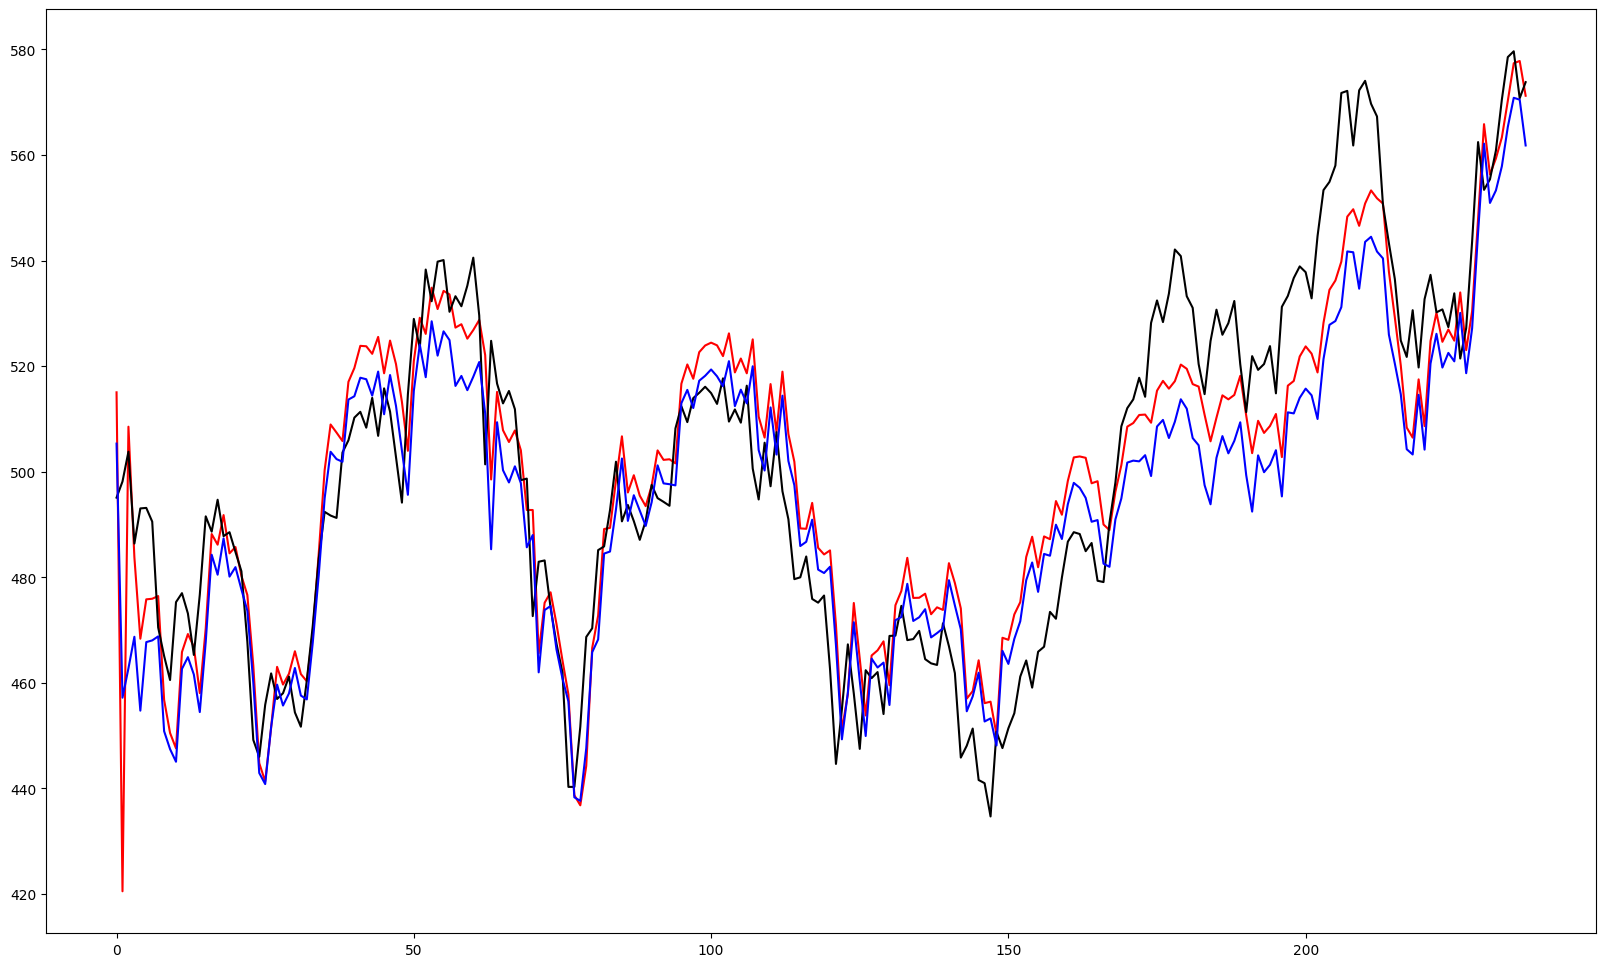

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 12]
plt.plot(sentiment_result,'red',pd.Series(actual.astype(float)),'black',without_sentiment_result,'blue')
plt.show()